In [1]:

# imports
import os
import sys
import types
import json

# figure size/format
fig_width = 7
fig_height = 5
fig_format = 'retina'
fig_dpi = 96

# matplotlib defaults / format
try:
  import matplotlib.pyplot as plt
  plt.rcParams['figure.figsize'] = (fig_width, fig_height)
  plt.rcParams['figure.dpi'] = fig_dpi
  plt.rcParams['savefig.dpi'] = fig_dpi
  from IPython.display import set_matplotlib_formats
  set_matplotlib_formats(fig_format)
except Exception:
  pass

# plotly use connected mode
try:
  import plotly.io as pio
  pio.renderers.default = "notebook_connected"
except Exception:
  pass

# enable pandas latex repr when targeting pdfs
try:
  import pandas as pd
  if fig_format == 'pdf':
    pd.set_option('display.latex.repr', True)
except Exception:
  pass



# output kernel dependencies
kernel_deps = dict()
for module in list(sys.modules.values()):
  # Some modules play games with sys.modules (e.g. email/__init__.py
  # in the standard library), and occasionally this can cause strange
  # failures in getattr.  Just ignore anything that's not an ordinary
  # module.
  if not isinstance(module, types.ModuleType):
    continue
  path = getattr(module, "__file__", None)
  if not path:
    continue
  if path.endswith(".pyc") or path.endswith(".pyo"):
    path = path[:-1]
  if not os.path.exists(path):
    continue
  kernel_deps[path] = os.stat(path).st_mtime
print(json.dumps(kernel_deps))

# set run_path if requested
if r'C:\Users\vcaminic\Desktop\github\carminemnc.github.io\notebooks\clustering':
  os.chdir(r'C:\Users\vcaminic\Desktop\github\carminemnc.github.io\notebooks\clustering')

# reset state
%reset

def ojs_define(**kwargs):
  import json
  try:
    # IPython 7.14 preferred import
    from IPython.display import display, HTML
  except:
    from IPython.core.display import display, HTML

  # do some minor magic for convenience when handling pandas
  # dataframes
  def convert(v):
    try:
      import pandas as pd
    except ModuleNotFoundError: # don't do the magic when pandas is not available
      return v
    if type(v) == pd.Series:
      v = pd.DataFrame(v)
    if type(v) == pd.DataFrame:
      j = json.loads(v.T.to_json(orient='split'))
      return dict((k,v) for (k,v) in zip(j["index"], j["data"]))
    else:
      return v
  
  v = dict(contents=list(dict(name=key, value=convert(value)) for (key, value) in kwargs.items()))
  display(HTML('<script type="ojs-define">' + json.dumps(v) + '</script>'), metadata=dict(ojs_define = True))
globals()["ojs_define"] = ojs_define


{"C:\\Program Files\\Python312\\Lib\\importlib\\_bootstrap.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\importlib\\_bootstrap_external.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\zipimport.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\codecs.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\encodings\\aliases.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\encodings\\__init__.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\encodings\\utf_8.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\encodings\\cp1252.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\abc.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\io.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\stat.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\_collections_abc.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\genericpath.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\ntpath.py": 1696245958.0, "C:\\Program Files\\Python312\\Lib\\o

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.cluster import KMeans
from yellowbrick.cluster import *  # for clustering diagnostics
from sklearn.metrics import silhouette_score

import warnings
# Suppress all warnings
warnings.filterwarnings("ignore")

# reading data
df = pd.read_csv('customer_segmentation.csv')
df = df.dropna()

# Automatically select categorical and numerical columns
categorical_cols = df.select_dtypes(include=['object', 'category']).columns
numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns

# Create a ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_cols),
        ('cat', OneHotEncoder(sparse_output=False, 
                              handle_unknown='ignore', 
                              drop=None,
                              dtype=float), categorical_cols)
    ])

# Fit and transform the data
data_processed = preprocessor.fit_transform(df)

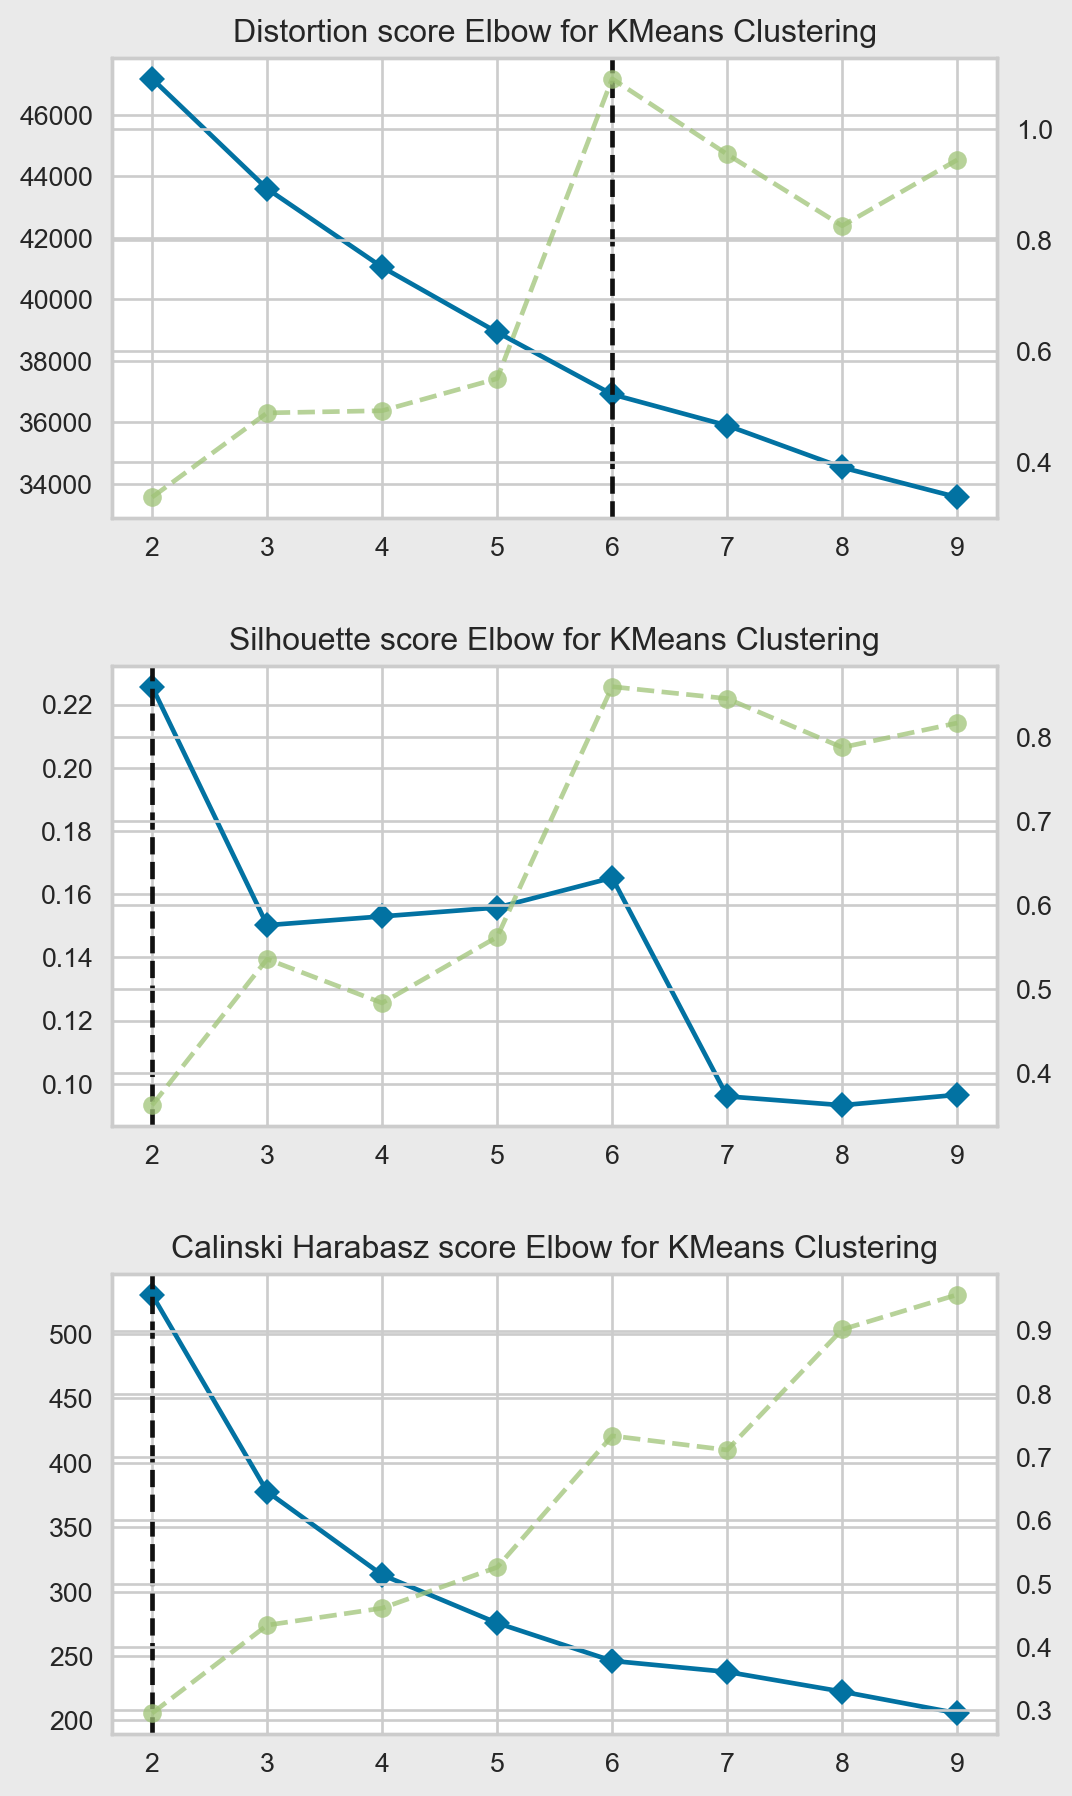

In [3]:
clusters_range = range(2,10)
bg = "#EAEAEA"

fig, ax = plt.subplots(nrows=3, ncols=1, figsize=(6, 10))
fig.tight_layout(pad=3)
fig.set_facecolor(bg)

km = KMeans(n_clusters=3, init='k-means++', n_init=12, max_iter=2000,algorithm="elkan")

# Distortion: mean sum of squared distances to centers
elb = KElbowVisualizer(km, k=clusters_range, ax=ax[0], locate_elbow=True,n_jobs=1)
elb.fit(data_processed)
# ax[0].legend(loc='upper left')
ax[0].set_title('Distortion score Elbow for KMeans Clustering')

# Silhouette: mean ratio of intra-cluster and nearest-cluster distance
sil = KElbowVisualizer(km, k=clusters_range, metric='silhouette', locate_elbow=True, ax=ax[1],n_jobs=1)
sil.fit(data_processed)
# ax[1].legend(loc='upper left')
ax[1].set_title('Silhouette score Elbow for KMeans Clustering')

# Calinski Harabasz: ratio of within to between cluster dispersion
cal = KElbowVisualizer(km, k=clusters_range, metric='calinski_harabasz', locate_elbow=True, ax=ax[2],n_jobs=1)
cal.fit(data_processed)
# ax[2].legend(loc='upper left')
ax[2].set_title('Calinski Harabasz score Elbow for KMeans Clustering')

plt.show()

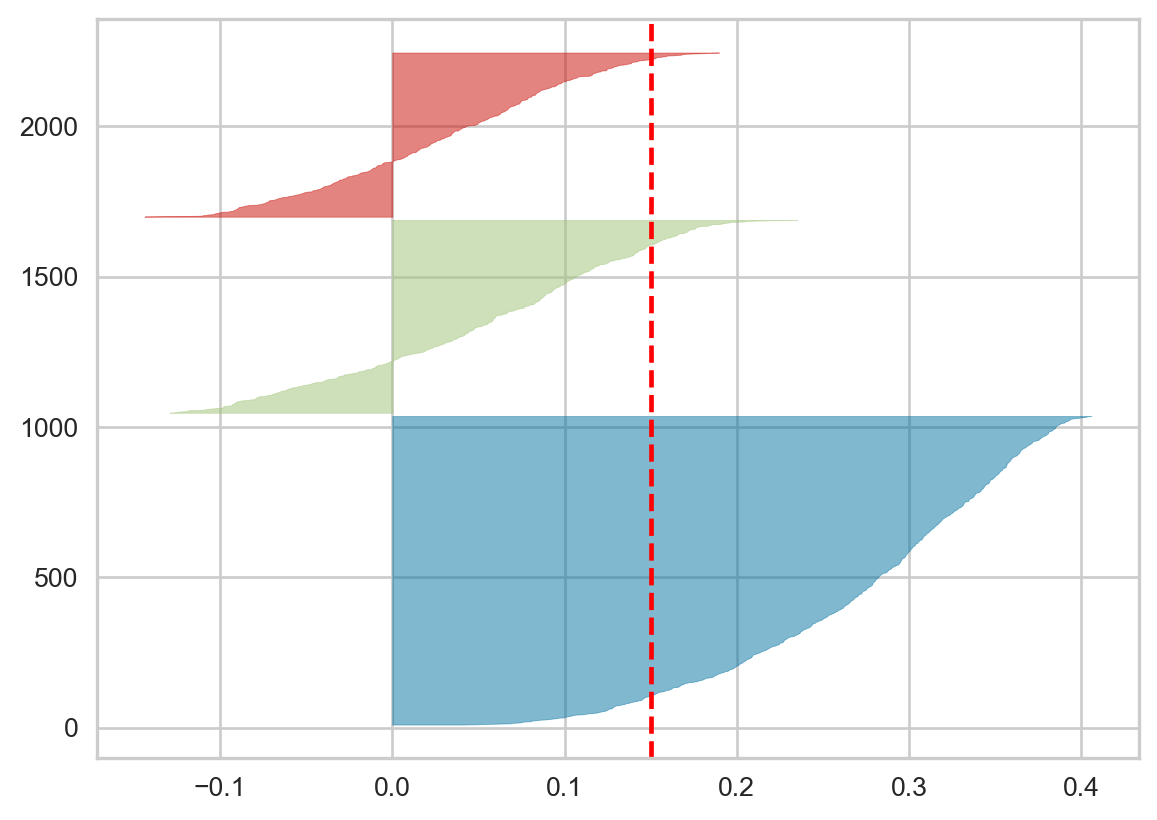

In [4]:
# fitting kmeans
km = KMeans(n_clusters=3, init='k-means++', n_init=12, max_iter=2000,algorithm="elkan")

# Calculate silhouette score
silhouette_avg = round(silhouette_score(data_processed, km.fit_predict(data_processed)), 4)

# silhouette coefficient plot
silhouette = SilhouetteVisualizer(km, colors='yellowbrick')
silhouette.fit(data_processed)

plt.show()

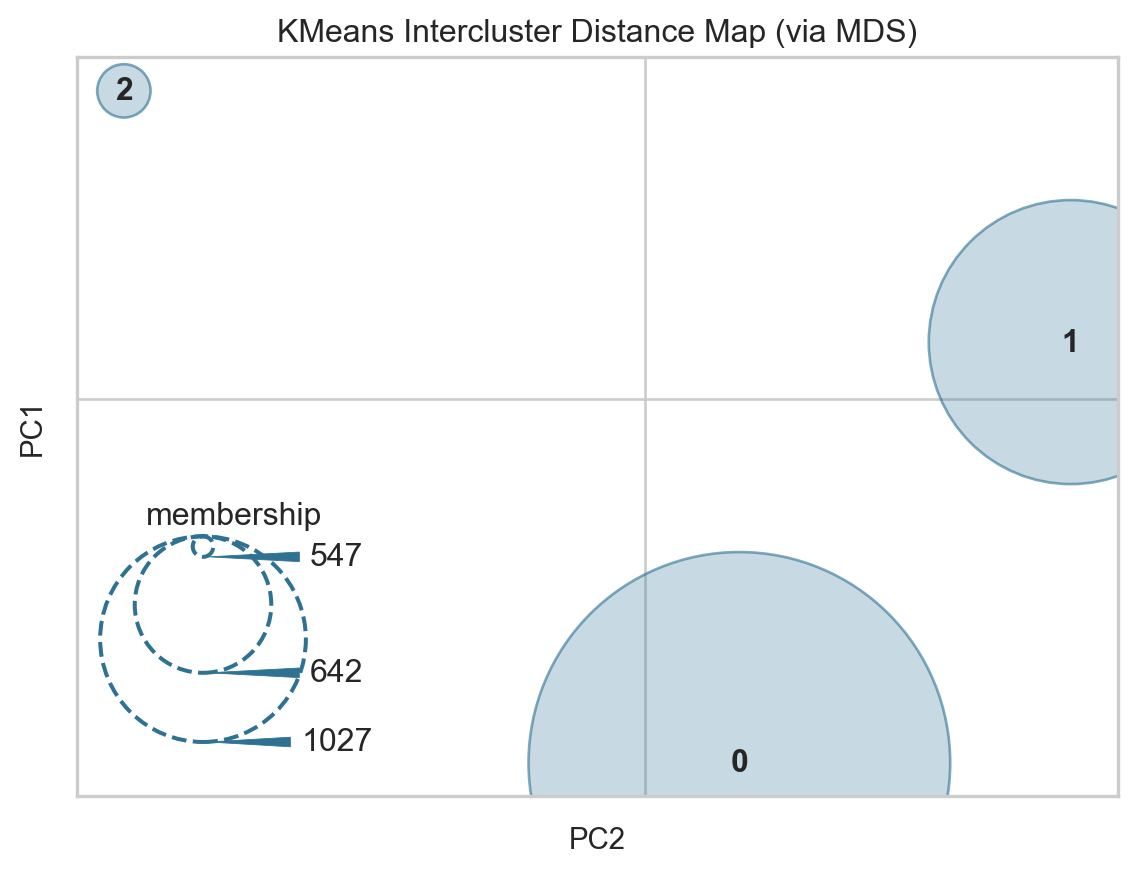

In [5]:
# intercluster distance plot
icd = InterclusterDistance(km, legend_loc='lower left')
icd.fit(data_processed)

icd.show()
plt.show()